#  **Forecasting Demand for a Company Using Time Series Analysis**

**Deskripsi singkat**:
* Proyek ini akan membahas tentang bagaimana melakukan peramalan atau prediksi terhadap permintaan jumlah produk pada perusahaan menggunakan analisis time series. Proyek ini akan mencakup pengumpulan data, analisis data, pemilihan model terbaik, dan prediksi untuk memperkirakan jumlah permintaan produk pada perusahaan dalam jangka waktu tertentu. Dalam proyek ini, teknik time series analysis akan digunakan untuk mengevaluasi data historis dan membuat prediksi terhadap permintaan di masa depan untuk membantu perusahaan untuk mempersiapkan stok produk yang diperlukan secara lebih efektif.

**Objektif**: 
* Mengembangkan model yang dapat memprediksi dengan akurat nilai penjualan produk tertentu di masa depan berdasarkan data historis. 
* Proyek ini juga bertujuan untuk memperkenalkan teknik dan konsep dasar dalam analisis time series, khususnya dalam pembuatan model forecasting dengan menggunakan metode-metode seperti ARIMA, SARIMA, dan Holt-Winters.

# Introduction

Name: Bagus Tirta Aji Hakim

A junior data scientist with logistic engineering background. Having knowledge in distribution, warehousing, and supply chain management. I have a non-formal data analysis educational experience in the Studi Independen Bersertifikat and Digital Talent Scholarship. Positively adaptable, willing to learn, ardworking, and passionate person with solid organizational skills. Ready to help the team to achieve company goals.

# External Link

Deployment: [Click Here](https://)

# Working Area

## 1 - Import Library

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import itertools
import statsmodels.api as sm
import pickle
import json

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error,mean_squared_error

## 2 - Data Loading

**About Dataset**

Column | Info
----- | -----
week_number | contained information about week of specific product sold, (2021-52 to 2023-14).
week_start_date | contained information about week start date of specific product sold.
week_end_date | contained information about week end date of specific product sold.
product_item | contained information about product item/product code (Variabel Bebas).
quantity | contained information about quantity of product in respective week.

In [83]:
data = pd.read_csv('https://raw.githubusercontent.com/ardhiraka/talent_fair_sample_challenge/main/datasets/sample_dataset_timeseries_noarea.csv')

In [84]:
data.head()

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119


In [85]:
data.tail()

,week_number,week_start_date,week_end_date,product_item,quantity
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920
102732,2023-14,2023-04-03,2023-04-09,fff18f7c705e729746515e2053dee64b,53


In [86]:
data_duplicate = data.copy()

Dengan cara ini, kita dapat memodifikasi atau mengubah nilai di dalam "data" tanpa mempengaruhi nilai di dalam "data_duplicate" atau data asli.

In [87]:
data.shape

(102733, 5)

* Shape menunjukkan bahwa data yang digunakan memiliki 102733 baris atau observasi dan 5 kolom atau variabel.

In [88]:
data.dtypes

week_number        object
week_start_date    object
week_end_date      object
product_item       object
quantity            int64
dtype: object

* Kolom `week_number`, `week_start_date`, `week_end_date`, dan `product_item` memiliki tipe data object, yang menunjukkan bahwa nilai dalam kolom tersebut berupa teks atau kombinasi teks dan angka.
* Kolom `quantity` memiliki tipe data int64, yang menunjukkan bahwa nilai dalam kolom tersebut berupa bilangan bulat.

Oleh karena itu perlu dilakukan trasnformasi data yaitu mengubah tipe data kolom menjadi tipe data menjadi datetime

In [89]:
data["week_start_date"] = pd.to_datetime(data["week_start_date"], format='%Y-%m-%d')
data["week_end_date"] = pd.to_datetime(data["week_end_date"], format='%Y-%m-%d')

In [90]:
data.dtypes

week_number                object
week_start_date    datetime64[ns]
week_end_date      datetime64[ns]
product_item               object
quantity                    int64
dtype: object

Kolom `week_start_date` dan `week_end_date` telah berhasil dirubah menjadi tipe data datetime.

Dengan mengubah tipe data kolom `week_start_date` dan `week_end_date` menjadi tipe data datetime, kita dapat melakukan operasi dan manipulasi tanggal pada kolom tersebut dengan lebih mudah dan efektif.

In [91]:
data.isna().sum()

week_number        0
week_start_date    0
week_end_date      0
product_item       2
quantity           0
dtype: int64

Tedapat dua missing values pada kolom `product_item` oleh karena itu kita dapat melakukan drop pada kolom tersebut karena jika dilakukan imputasi akan menimbulkan bias.

In [92]:
data = data.dropna(axis=0)

In [93]:
data.isna().sum()

week_number        0
week_start_date    0
week_end_date      0
product_item       0
quantity           0
dtype: int64

Data telah bersih dari missing values

## 3 - Exploratory Data Analysis

### Product Item

In [94]:
data['product_item'].nunique()

2309

Terdapat 2309 unique value/product yang berbeda pada kolom "product_item" di dalam dataset

In [95]:
sum_product = data['product_item'].value_counts().reset_index()
sum_product = sum_product.rename(columns={'index': 'product_item', 'product_item': 'total_item'})
sum_product

,product_item,total_item
0,0073377087c7ddace313ff829cd7b0b3,67
1,870b3ad8c41b746b29ba31f6e4040950,67
2,9264576b8833b892b34a39525bcdd271,67
3,921cfbd1930eeee6b82a7b053c4ed8dc,67
4,91f65f29b32c39788b4294cbe2be7024,67
...,...,...
2304,d97d3a3e53124b6b1a8313403f54f6b8,1
2305,d963020bd8d76659c6768ad252be9629,1
2306,d4e90f2dcbcf53757d6bd1f3b6f368cb,1
2307,170ad92bf82a3509886ceb841cd6e3c3,1


Jumlah maksimum dari product_item adalah sebanyak 67 item dan jumlah minimum dari product_item sebanyak 1 item saja.

### Tanggal

In [96]:
week_13 = data[data['week_number'] == '2023-13']

mengambil data pada minggu ke 13

In [97]:
week_13['week_start_date'].min()

Timestamp('2023-03-27 00:00:00')

pada minggu ke 13 dimulai pada tanggal 27 Maret

In [98]:
week_13['week_end_date'].max()

Timestamp('2023-04-02 00:00:00')

pada minggu ke 13 diakhiri pada tanggal 02 April

Dapat disimpulkan bahwa data berupa data mingguan yang dimulai dari Hari Senin dan diakhiri pada Hari Minggu.

### Observe with Visualization

In [99]:
data_week = data.groupby('week_end_date')['quantity'].sum()

# convert to DataFrame
data_week = data_week.reset_index()

# print the result
data_week

,week_end_date,quantity
0,2022-01-02,128808
1,2022-01-09,3839557
2,2022-01-16,4138934
3,2022-01-23,4149077
4,2022-01-30,4824273
...,...,...
62,2023-03-12,4775638
63,2023-03-19,4787111
64,2023-03-26,4757590
65,2023-04-02,6001166


Melakukan pengelompokkan untuk data di setiap minggunya dengan melakukan penjumlahan pada quantity dari semua product item di minggu tersebut.

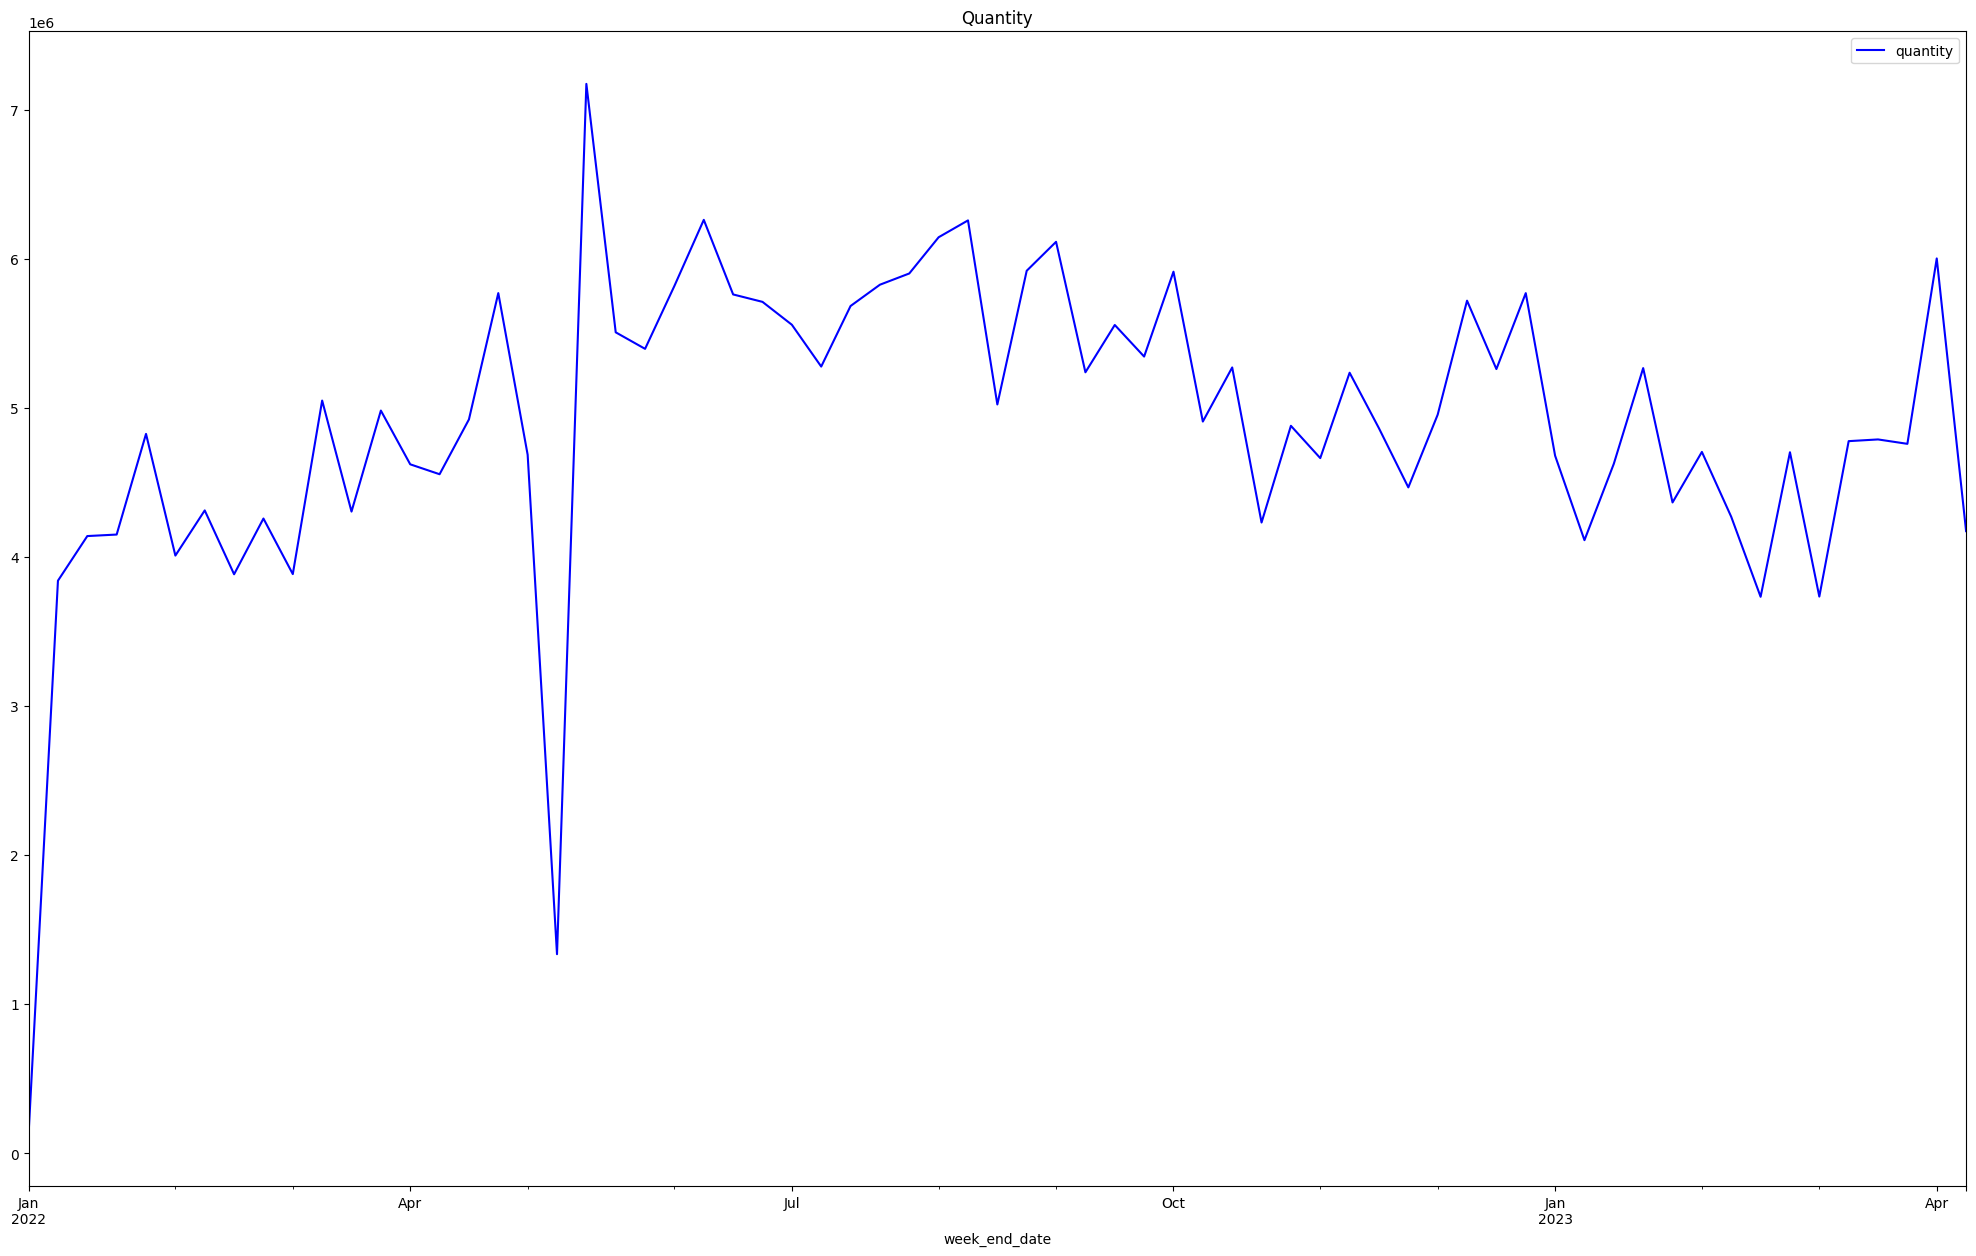

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
data_week.plot.line(x='week_end_date', y='quantity', color='b', title ='Quantity', ax = axes, rot=0)
plt.show()

Dari grafik tersebut dapat diketahui bahwa proses yang diamati tidak stasioner dan sulit untuk menentukan adanya seasonality.

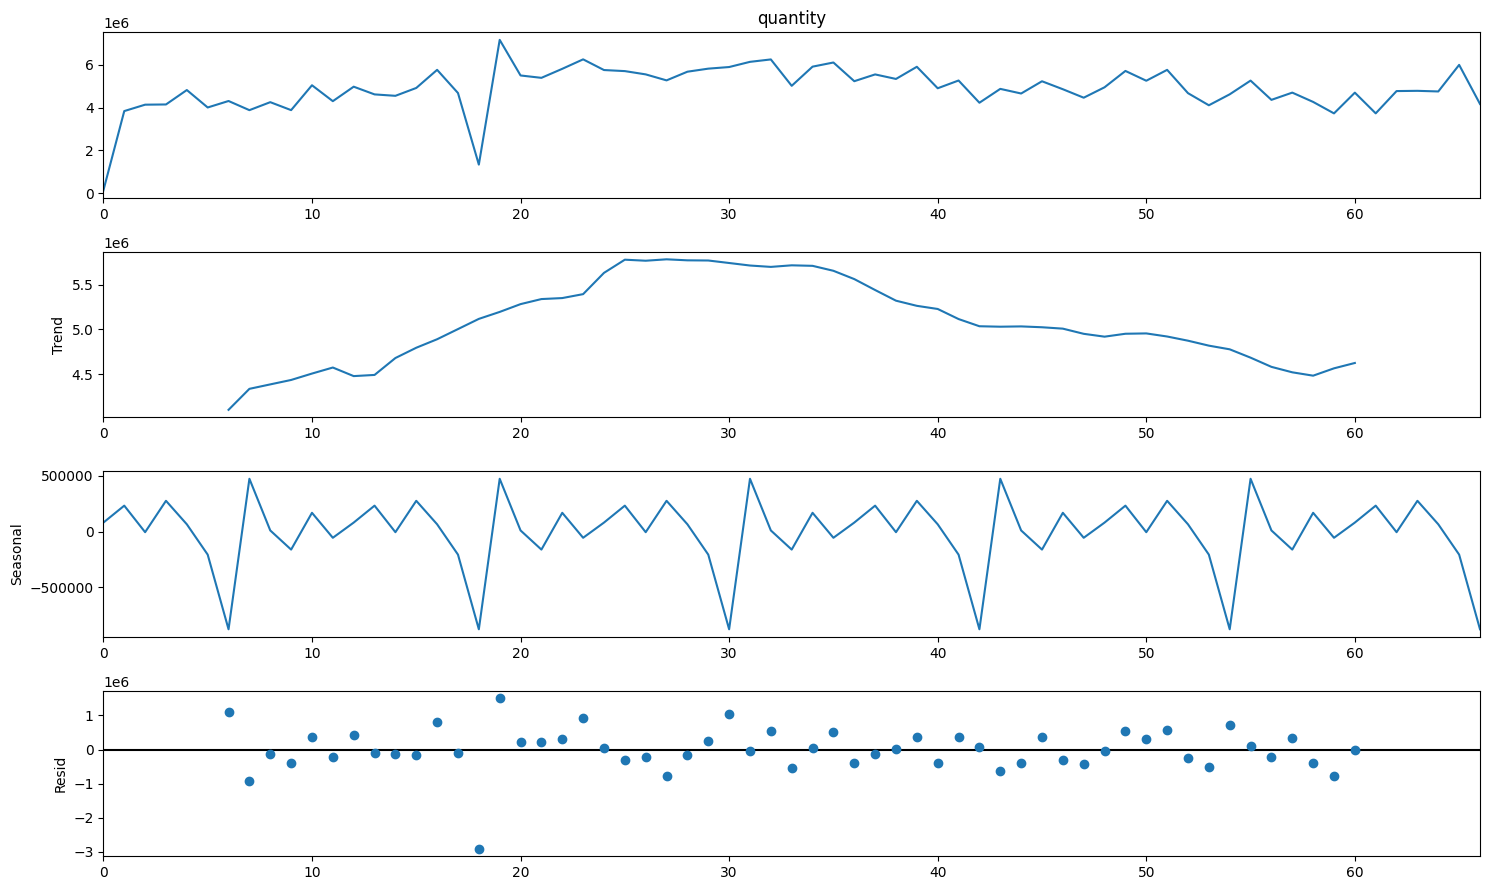

In [101]:
pylab.rcParams['figure.figsize'] = (15, 9)

#We try to look at the data in yearly period, since the data are in monthly period, we aggregate it into 12 period
res = seasonal_decompose(data_week['quantity'],model='additive', period = 12)
ax=res.plot()
plt.show()

* Dekomposisi musiman digunakan untuk memisahkan suatu rangkaian waktu menjadi tiga komponen utama, yaitu tren (trend), musiman (seasonality), dan sisa (residual). Komponen-komponen ini dapat membantu kita memahami pola yang ada pada data dan memperoleh informasi penting dalam merencanakan kegiatan bisnis atau pengambilan keputusan.

* Berdasarkan hasil decomposing, dapat dipastikan bahwa data yang kita temui merupakan data seasonality



In [102]:
data_week['quantity'].mean()

4893709.194029851

Rata-rata quantity di setiap minggunya sebanyak 4,893,709.194029851

## 4 - Feature Engineering

### **Split Train set dan Test set**

In [103]:
data_week.set_index('week_end_date',inplace=True)

In [104]:
train=data_week[:57]
test=data_week[57:]

In [105]:
train.shape

(57, 1)

In [106]:
test.shape

(10, 1)

## 5 - Modelling

### Observe the Stationarity 

* Tujuan dari melakukan cek stasioner pada time series adalah untuk memastikan apakah rata-rata, variansi, dan kovarians time series konstan atau tidak. Jika data stasioner, maka kita dapat mengasumsikan bahwa pola yang ada pada data akan tetap sama di masa depan.

* Jika data tidak stasioner, maka kita perlu melakukan transformasi data seperti differencing, detrending, atau membuat model ARIMA untuk membuat data menjadi stasioner sebelum menerapkan model statistik lainnya.

Methods to Check Stationarity is using Augmented Dickey-Fuller (ADF) Test

In [107]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [108]:
# check stasionerity
print("data train stasionarity")
check_stationarity(train['quantity'])

data train stasionarity
ADF Statistic: -7.375601
p-value: 0.000000
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
Stationary


Dalam output di atas, hasil pengujian menunjukkan bahwa data train kolom `quantity` merupakan data time series yang stasioner karena nilai p-value 0.000000 kurang dari alpha 0.05, dan nilai ADF Statistic -7.375601 lebih kecil dari nilai kritis pada level signifikansi 1%, 5%, dan 10%.

### ACF and PACF

<Figure size 1200x600 with 0 Axes>

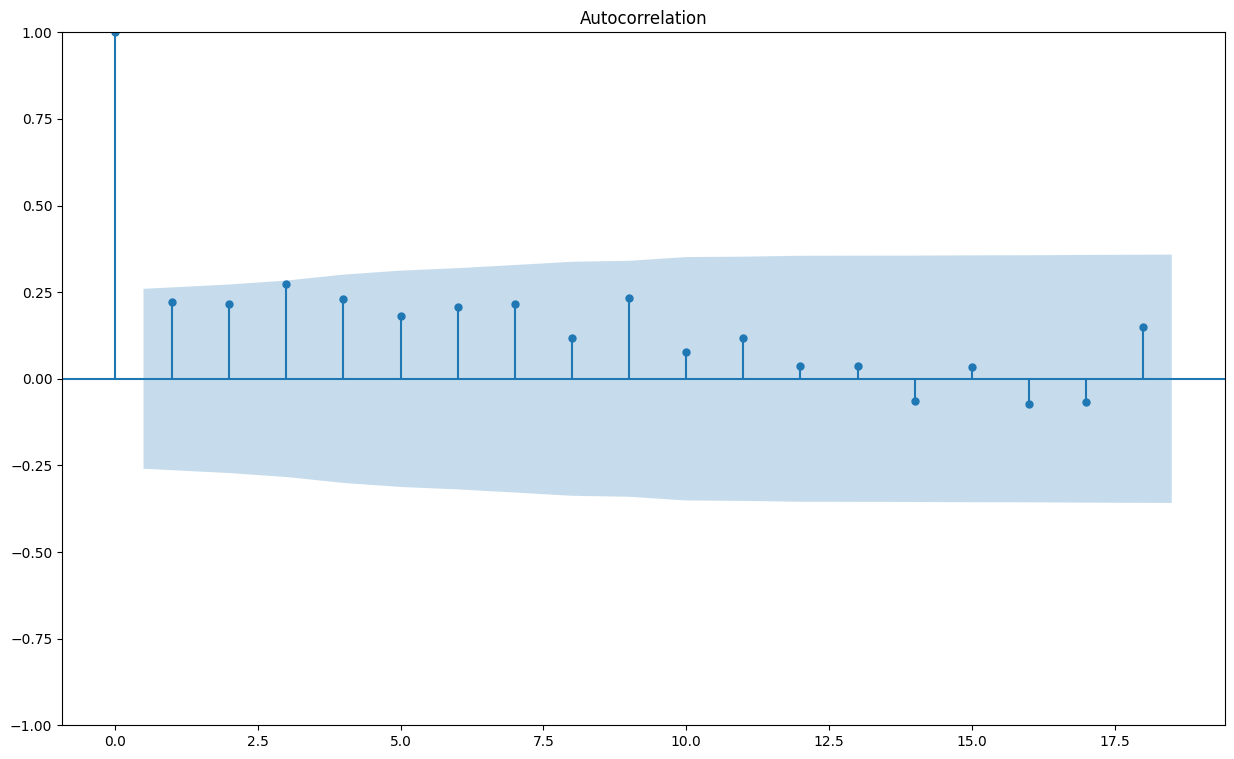

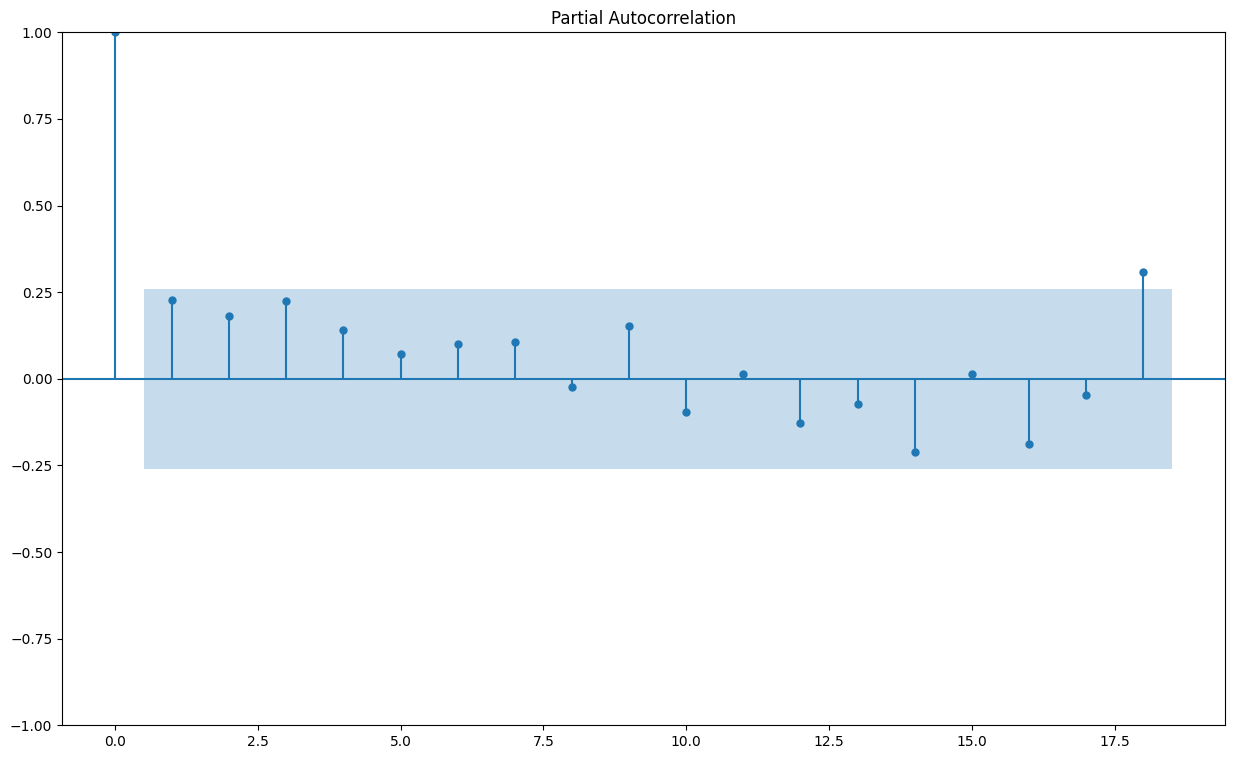

In [109]:
plt.figure(figsize=(12, 6))
plot_acf(train['quantity'])
plot_pacf(train['quantity'])
plt.show()

**Plot ACF** (Autocorrelation Function) adalah grafik yang menunjukkan nilai korelasi antara suatu variabel dengan dirinya sendiri pada waktu yang berbeda

**Plot PACF** (Partial Autocorrelation Function) adalah grafik yang menunjukkan korelasi parsial antara suatu variabel dan dirinya sendiri pada waktu yang berbeda setelah menghilangkan pengaruh korelasi dari lag-lag sebelumnya

**Adapun hasil dari grafik ACF dan PCAF adalah sebagai berikut:**

* Pada grafik ACF menunjukkan bahwa pada Lag 0 (sumbu x) memiliki nilai korelasi yang tinggi yaitu 1 (sumbu y) karena tentunya variabel memiliki nilai korelasi yang sempurna dengan dirinya sendiri pada waktu yang sama

* Grafik mulai turun drastis setelah Lag 0, hal ini menunjukkan nilai korelasi yang sangat kecil antara variabel waktu yang berbeda

**Tujuan menggunakan ACF dan PCAF**
* plot ACF dan PACF sangat penting dalam menganalisis deret waktu dan memodelkannya menggunakan model ARIMA dan SARIMA. Plot ACF digunakan untuk mengidentifikasi model Moving Average (MA), sementara plot PACF digunakan untuk mengidentifikasi model Autoregressive (AR). Plot ACF dan PACF juga digunakan dalam model SARIMA untuk mengidentifikasi efek musiman pada deret waktu.





### **Uji Coba 1**

Melakukan modelling menggunakan ARIMA

In [110]:
import warnings
warnings.filterwarnings('ignore')

In [111]:
arima=ARIMA(train,order=(1,1,1))
mod_train=arima.fit()
mod_train.aic

1725.4523432769738

* Membuat objek arima dengan menginisialisasi kelas ARIMA dan menentukan set data train dan parameter model ARIMA (1,1,1).

In [112]:
y_pred_train=pd.Series(mod_train.predict(100)[0],index=train.index)
y_pred_train=pd.DataFrame(y_pred_train)
y_pred_train.columns=['quantity_predict']

* Menghasilkan prediksi untuk 100 observasi terakhir dari set data train

In [113]:
y_pred_train

,quantity_predict
week_end_date,
2022-01-02,4.706903e+06
2022-01-09,4.706903e+06
2022-01-16,4.706903e+06
2022-01-23,4.706903e+06
2022-01-30,4.706903e+06
2022-02-06,4.706903e+06
2022-02-13,4.706903e+06
2022-02-20,4.706903e+06
2022-02-27,4.706903e+06


In [114]:
y_pred_test=pd.Series(mod_train.predict(100)[0],index=test.index)
y_pred_test=pd.DataFrame(y_pred_test)
y_pred_test.columns=['quantity_predict']

In [115]:
act_vs_pred=pd.concat([test,y_pred_test], axis=1)
act_vs_pred

,quantity,quantity_predict
week_end_date,,
2023-02-05,4703388,4.706903e+06
2023-02-12,4267946,4.706903e+06
2023-02-19,3731588,4.706903e+06
2023-02-26,4701262,4.706903e+06
2023-03-05,3732954,4.706903e+06
2023-03-12,4775638,4.706903e+06
2023-03-19,4787111,4.706903e+06
2023-03-26,4757590,4.706903e+06
2023-04-02,6001166,4.706903e+06


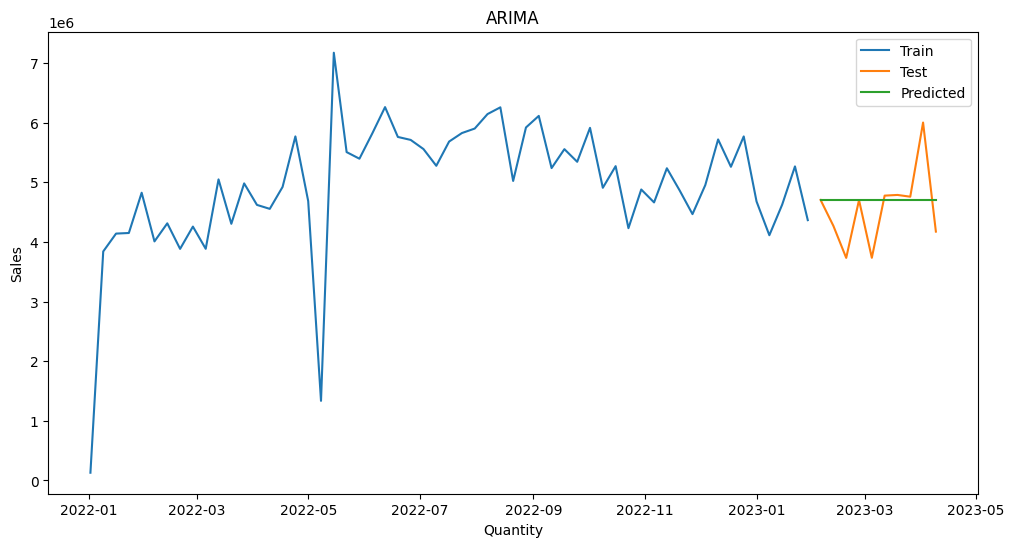

In [116]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['quantity'], label='Train')
plt.plot(test.index, test['quantity'], label='Test')
plt.plot(y_pred_test.index, y_pred_test['quantity_predict'], label='Predicted')
plt.title('ARIMA')
plt.xlabel('Quantity')
plt.ylabel('Sales')
plt.legend()
plt.show()

> Model Evaluation

In [117]:
print('MAE train =', mean_absolute_error(train, y_pred_train))
print('MAE test =', mean_absolute_error(test, y_pred_test))

MAE train = 792748.2395502614
MAE test = 442610.30460846797


* Evaluasi model tersebut didasarkan pada pengukuran Mean Absolute Error (MAE) pada data train dan test. MAE adalah suatu metrik evaluasi yang mengukur rata-rata selisih absolut antara nilai prediksi dan nilai aktual pada dataset yang diberikan.

* Dalam kasus ini, model yang dievaluasi menghasilkan MAE sebesar 792748.2395502614 pada data train dan 442610.30460846797 pada data test. MAE yang lebih kecil pada data test menunjukkan bahwa model tersebut mampu lebih akurat dalam memprediksi nilai pada data yang belum pernah dilihat sebelumnya, dibandingkan dengan data yang sudah dipelajari oleh model pada saat training.

* Namun, secara keseluruhan, nilai MAE yang relatif besar pada kedua dataset menunjukkan bahwa model masih memiliki tingkat kesalahan yang cukup tinggi dalam memprediksi nilai target.

* Oleh karena itu, model ARIMA tersebut masih memerlukan penyempurnaan lebih lanjut agar dapat menghasilkan prediksi yang lebih akurat. Beberapa hal yang dapat dilakukan untuk meningkatkan performa model antara lain melakukan penyesuaian nilai p, d, dan q, mempertimbangkan menggunakan model ARIMA yang lebih kompleks seperti SARIMA, melakukan deteksi dan penghapusan outliers pada data, dan mempertimbangkan menggunakan metode pemodelan lain yang lebih cocok untuk data yang ada.

> Input hasil MAE ke dalam DataFrame

In [118]:
data_mae = {'Model': ['Model ARIMA', 'Model B', 'Model C'], 
            'MAE Train': [792748.2395502614, 1.8, 3.2], 
            'MAE Test': [442610.30460846797, 1.8, 3.2]}
df_mae = pd.DataFrame(data_mae)
df_mae

,Model,MAE Train,MAE Test
0,Model ARIMA,792748.23955,442610.304608
1,Model B,1.80000,1.800000
2,Model C,3.20000,3.200000


### **Uji Coba 2 (Improvement)**

Berdasarkan hasil modelling yang telah digunakan sebelumnya, maka perlu melakukan peningkatan performa model dengan menggunakan SARIMA.

In [119]:
# create SARIMA model
model_2 = sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1), seasonal_order=(1,1,1,10))

# fit the model
results_2 = model_2.fit()

* Parameter order=(1, 1, 1) pada model SARIMA merupakan nilai derajat autoregression (p), derajat diferensiasi (d), dan derajat moving average (q) pada model ARIMA.
* model SARIMA memiliki derajat autoregression 1 (p), derajat diferensiasi 1 (d), dan derajat moving average 1 (q) pada model ARIMA, serta derajat autoregression 1 (P), derajat diferensiasi 1 (D), derajat moving average 1 (Q), dan musimanitas (seasonality) 10

> Melakukan predict menggunakan fungsi predict() pada model SARIMA yang telah dibuat.

In [120]:
# get predicted values for train and test sets
train_pred = results_2.predict(start=train.index[0], end=train.index[-1])
test_pred = results_2.predict(start=test.index[0], end=test.index[-1])

> Membuat plot grafik yang menunjukkan nilai aktual dan prediksi dari model SARIMA untuk data train dan test.

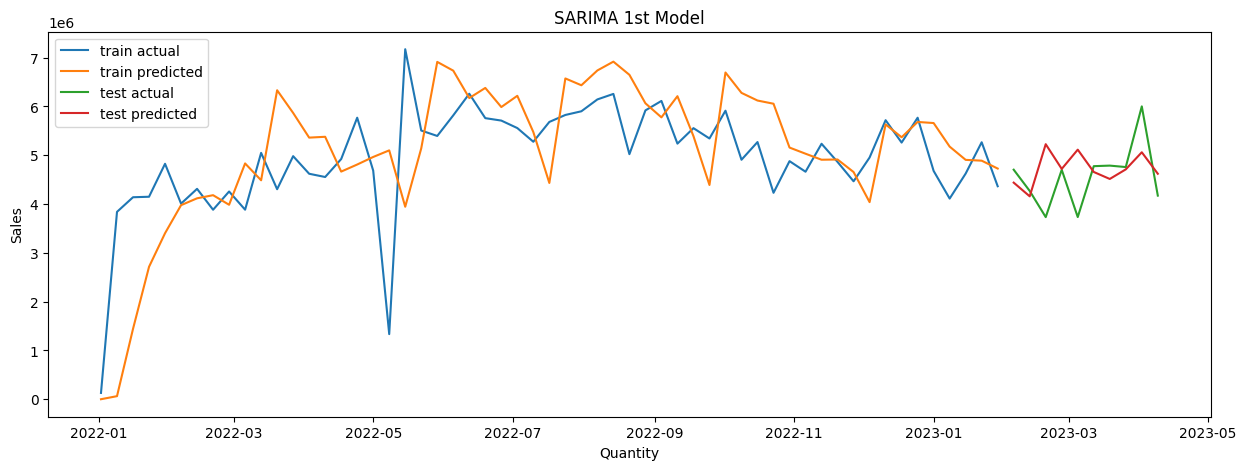

In [121]:
# plot predicted values and actual values for train set
plt.figure(figsize=(15, 5))
plt.plot(train.index, train, label='train actual')
plt.plot(train_pred.index, train_pred, label='train predicted')
plt.plot(test.index, test, label='test actual')
plt.plot(test_pred.index, test_pred, label='test predicted')
plt.title('SARIMA 1st Model')
plt.xlabel('Quantity')
plt.ylabel('Sales')
plt.legend()
plt.show()

> Model Evaluation

In [122]:
print("MAE Train =", mean_absolute_error(train, train_pred))
print("MAE test =", mean_absolute_error(test, test_pred))

MAE Train = 836297.5710424295
MAE test = 509819.2214281188


* Dalam kasus ini, model yang dievaluasi menghasilkan MAE sebesar 836297.5710424295 pada data train dan 836297.5710424295 pada data test. MAE yang lebih kecil pada data test menunjukkan bahwa model tersebut mampu lebih akurat dalam memprediksi nilai pada data yang belum pernah dilihat sebelumnya, dibandingkan dengan data yang sudah dipelajari oleh model pada saat training.

* Namun, secara keseluruhan, nilai MAE yang relatif besar pada kedua dataset menunjukkan bahwa model masih memiliki tingkat kesalahan yang cukup tinggi dalam memprediksi nilai target.


> Input hasil MAE ke dalam DataFrame

In [123]:
data_mae = {'Model': ['Model ARIMA', 'SARIMA (1)', 'Model C'], 
            'MAE Train': [792748.2395502614, 836297.5710424295, 3.2], 
            'MAE Test': [442610.30460846797, 836297.5710424295, 3.2]}
df_mae = pd.DataFrame(data_mae)
df_mae

,Model,MAE Train,MAE Test
0,Model ARIMA,792748.239550,442610.304608
1,SARIMA (1),836297.571042,836297.571042
2,Model C,3.200000,3.200000


### Uji Coba 3 (Improvement)

In [124]:
# create SARIMA model
model_3 = sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1), seasonal_order=(1,1,1,12))

# fit the model
results_3 = model_3.fit()

* Parameter order=(1, 1, 1) pada model SARIMA merupakan nilai derajat autoregression (p), derajat diferensiasi (d), dan derajat moving average (q) pada model ARIMA.
* model SARIMA memiliki derajat autoregression 1 (p), derajat diferensiasi 1 (d), dan derajat moving average 1 (q) pada model ARIMA, serta derajat autoregression 1 (P), derajat diferensiasi 1 (D), derajat moving average 1 (Q), dan musimanitas (seasonality) 12

> Melakukan predict menggunakan fungsi predict() pada model SARIMA yang telah dibuat.

In [125]:
# get predicted values for train and test sets
train_pred = results_3.predict(start=train.index[0], end=train.index[-1])
test_pred = results_3.predict(start=test.index[0], end=test.index[-1])

Pertama, digunakan fungsi predict() pada model SARIMA yang telah dibuat, dan parameter `start` dan `end` disesuaikan dengan indeks awal dan indeks akhir dari data `train` dan `test` secara berturut-turut.
Kemudian, nilai prediksi untuk data train disimpan dalam variabel `train_pred`, dan nilai prediksi untuk data test disimpan dalam variabel `test_pred`

> Membuat plot grafik yang menunjukkan nilai aktual dan prediksi dari model SARIMA untuk data train dan test.

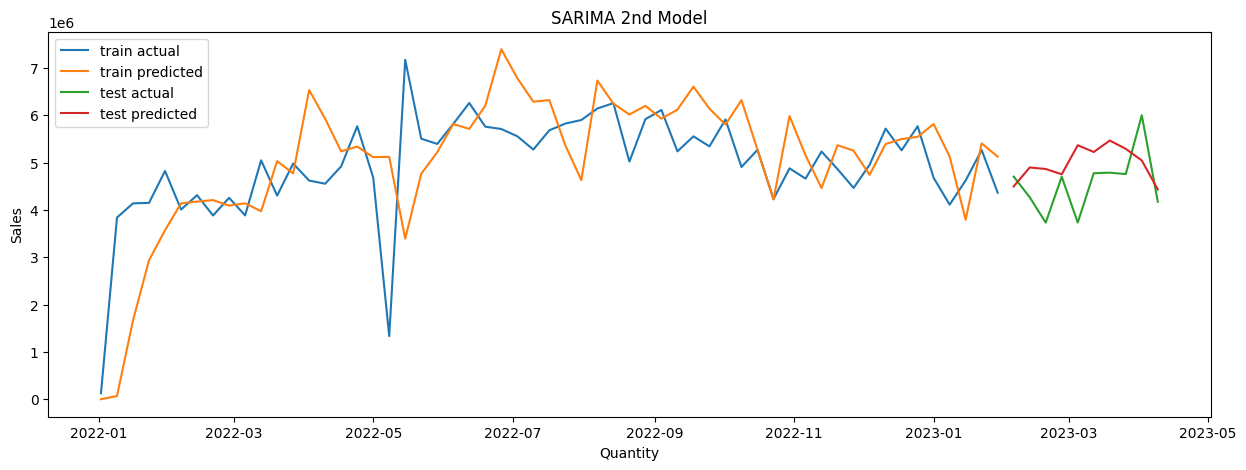

In [126]:
# plot predicted values and actual values for train set
plt.figure(figsize=(15, 5))
plt.plot(train.index, train, label='train actual')
plt.plot(train_pred.index, train_pred, label='train predicted')
plt.plot(test.index, test, label='test actual')
plt.plot(test_pred.index, test_pred, label='test predicted')
plt.title('SARIMA 2nd Model')
plt.xlabel('Quantity')
plt.ylabel('Sales')
plt.legend()
plt.show()

> Model Evaluation

In [127]:
print("MAE Train =", mean_absolute_error(train, train_pred))
print("MAE test =", mean_absolute_error(test, test_pred))

MAE Train = 823993.2215425053
MAE test = 653516.9306824275


* Dalam kasus ini, nilai MAE pada data train lebih tinggi daripada pada data test, yang menunjukkan bahwa model memiliki kecenderungan overfitting pada data train dan belum mampu secara akurat menggeneralisasi pada data yang belum pernah dilihat sebelumnya. Selain itu, nilai MAE pada data test masih cukup tinggi, sehingga model masih perlu diperbaiki atau dioptimalkan lebih lanjut.



> Input hasil MAE ke dalam DataFrame

In [128]:
data_mae = {'Model': ['Model ARIMA', 'SARIMA (1)', 'SARIMA (2)'], 
            'MAE Train': [792748.2395502614, 836297.5710424295, 823993.2215425053], 
            'MAE Test': [442610.30460846797, 836297.5710424295, 653516.9306824275]}
df_mae = pd.DataFrame(data_mae)
df_mae

,Model,MAE Train,MAE Test
0,Model ARIMA,792748.239550,442610.304608
1,SARIMA (1),836297.571042,836297.571042
2,SARIMA (2),823993.221543,653516.930682


### Uji Coba 4 (Improvement)

In [129]:
# create SARIMA model
model_4 = sm.tsa.statespace.SARIMAX(train,order=(2, 1, 2), seasonal_order=(1,1,1,12))

# fit the model
results_4 = model_4.fit()

> Melakukan predict menggunakan fungsi predict() pada model SARIMA yang telah dibuat.

In [130]:
# get predicted values for train and test sets
train_pred = results_4.predict(start=train.index[0], end=train.index[-1])
test_pred = results_4.predict(start=test.index[0], end=test.index[-1])

> Membuat plot grafik yang menunjukkan nilai aktual dan prediksi dari model SARIMA untuk data train dan test.

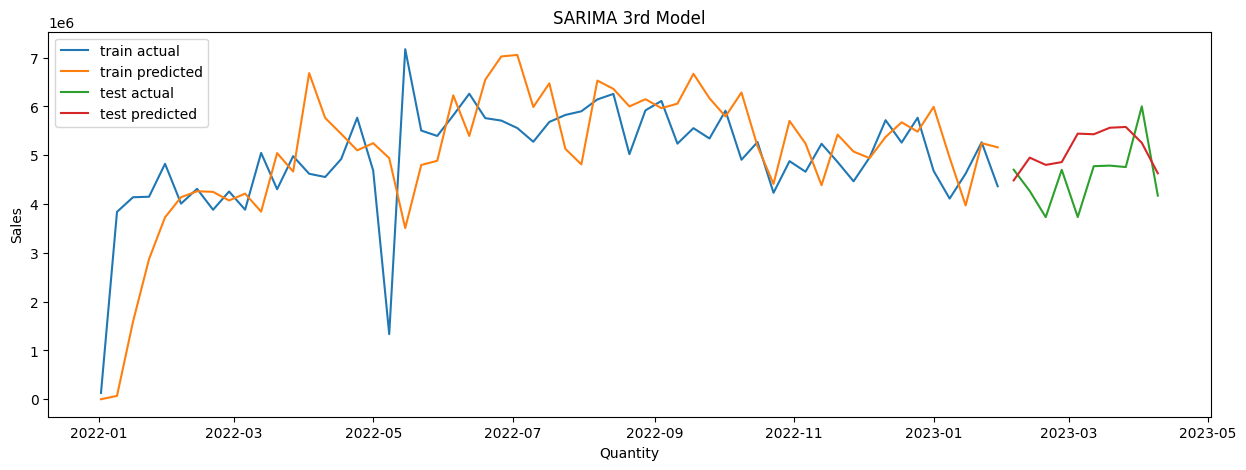

In [131]:
# plot predicted values and actual values for train set
plt.figure(figsize=(15, 5))
plt.plot(train.index, train, label='train actual')
plt.plot(train_pred.index, train_pred, label='train predicted')
plt.plot(test.index, test, label='test actual')
plt.plot(test_pred.index, test_pred, label='test predicted')
plt.title('SARIMA 3rd Model')
plt.xlabel('Quantity')
plt.ylabel('Sales')
plt.legend()
plt.show()

> Model Evaluation

In [132]:
print("MAE Train =", mean_absolute_error(train, train_pred))
print("MAE test =", mean_absolute_error(test, test_pred))

MAE Train = 846958.6098581993
MAE test = 729537.877542069


* Dalam kasus ini, nilai MAE pada data train lebih tinggi daripada pada data test, yang menunjukkan bahwa model memiliki kecenderungan overfitting pada data train dan belum mampu secara akurat menggeneralisasi pada data yang belum pernah dilihat sebelumnya. Selain itu, nilai MAE pada data test masih cukup tinggi, sehingga model masih perlu diperbaiki atau dioptimalkan lebih lanjut.

In [133]:
data_mae = {'Model': ['Model ARIMA', 'SARIMA (1)', 'SARIMA (2)', 'SARIMA (3)'], 
            'MAE Train': [792748.2395502614, 836297.5710424295, 823993.2215425053, 846958.6098581993], 
            'MAE Test': [442610.30460846797, 836297.5710424295, 653516.9306824275, 729537.877542069]}
df_mae = pd.DataFrame(data_mae)
df_mae

,Model,MAE Train,MAE Test
0,Model ARIMA,792748.239550,442610.304608
1,SARIMA (1),836297.571042,836297.571042
2,SARIMA (2),823993.221543,653516.930682
3,SARIMA (3),846958.609858,729537.877542


### Uji Coba 5 (Improvement)

In [54]:
# define the p, d, q and P, D, Q values to use
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
S = 10  # set seasonality to 12

# create a list of all possible combinations of parameter values
pdq = list(itertools.product(p, d, q))
PDQ = list(itertools.product(P, D, Q))
seasonal_pdq = [(x[0], x[1], x[2], S) for x in list(itertools.product(p, d, q))]

In [55]:
# create a function to fit a SARIMA model and return AIC
def sarima_model(data, pdq, PDQ, seasonal_pdq):
    model = sm.tsa.statespace.SARIMAX(data, order=pdq, seasonal_order=(PDQ[0], PDQ[1], PDQ[2], S), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    return results.aic

In [56]:
# loop through all possible combinations of parameters and store the results in a dataframe
results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            aic = sarima_model(train, param, param_seasonal, seasonal_pdq)
            results.append((param, param_seasonal, aic))
        except:
            continue

In [57]:
# create a dataframe from the results and sort by AIC in ascending order
results_df = pd.DataFrame(results, columns=['pdq', 'seasonal_pdq', 'aic'])
results_df = results_df.sort_values('aic')

# print the best parameter combination
print("Best Parameter Combination: ", results_df.iloc[0]['pdq'], results_df.iloc[0]['seasonal_pdq'])

Best Parameter Combination:  (0, 2, 1) (2, 2, 1, 10)


In [58]:
# create SARIMA model
model_5 = sm.tsa.statespace.SARIMAX(train,order=results_df.iloc[0]['pdq'], seasonal_order=results_df.iloc[0]['seasonal_pdq'])

# fit the model
results_5 = model_5.fit()

> Melakukan predict menggunakan fungsi predict() pada model SARIMA yang telah dibuat.

In [59]:
# get predicted values for train and test sets
train_pred = results_5.predict(start=train.index[0], end=train.index[-1])
test_pred = results_5.predict(start=test.index[0], end=test.index[-1])

> Membuat plot grafik yang menunjukkan nilai aktual dan prediksi dari model SARIMA untuk data train dan test.

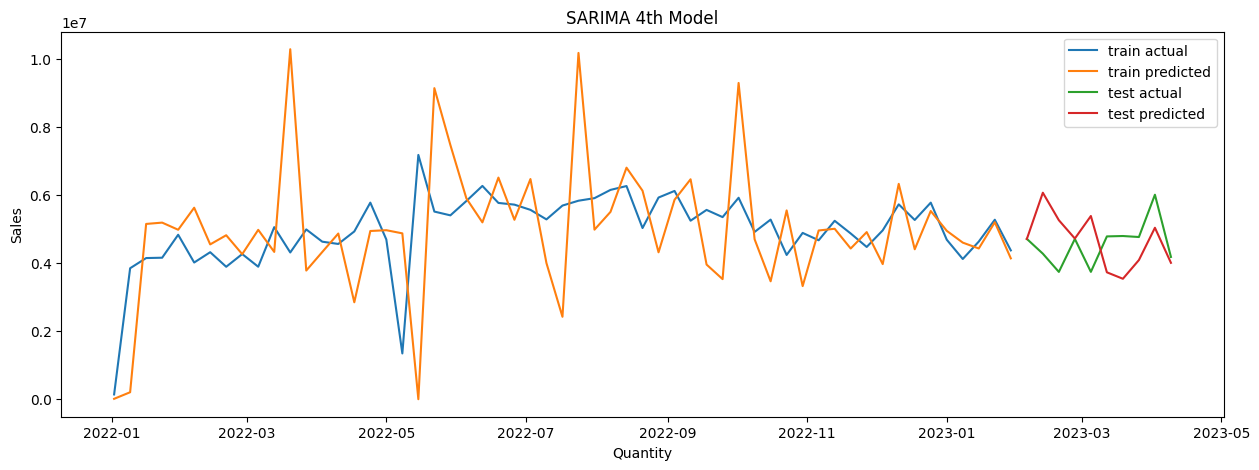

In [70]:
# plot predicted values and actual values for train set
plt.figure(figsize=(15, 5))
plt.plot(train.index, train, label='train actual')
plt.plot(train_pred.index, train_pred, label='train predicted')
plt.plot(test.index, test, label='test actual')
plt.plot(test_pred.index, test_pred, label='test predicted')
plt.title('SARIMA 4th Model')
plt.xlabel('Quantity')
plt.ylabel('Sales')
plt.legend()
plt.show()

> Model Evaluation

In [61]:
print("MAE Train =", mean_absolute_error(train, train_pred))
print("MAE test =", mean_absolute_error(test, test_pred))

MAE Train = 1288661.0073951231
MAE test = 910824.2692686388


* Dalam kasus ini, nilai MAE pada data train lebih tinggi daripada pada data test, yang menunjukkan bahwa model memiliki kecenderungan overfitting pada data train dan belum mampu secara akurat menggeneralisasi pada data yang belum pernah dilihat sebelumnya. Selain itu, nilai MAE pada data test masih cukup tinggi, sehingga model masih perlu diperbaiki atau dioptimalkan lebih lanjut.

> Input hasil MAE ke dalam DataFrame

In [62]:
data_mae = {'Model': ['Model ARIMA', 'SARIMA (1)', 'SARIMA (2)', 'SARIMA (3)', 'SARIMA (4)'], 
            'MAE Train': [792748.2395502614, 836297.5710424295, 823993.2215425053, 846958.6098581993, 1288661.0073951231], 
            'MAE Test': [442610.30460846797, 836297.5710424295, 653516.9306824275, 729537.877542069, 910824.2692686388]}
df_mae = pd.DataFrame(data_mae)
df_mae

,Model,MAE Train,MAE Test
0,Model ARIMA,7.927482e+05,442610.304608
1,SARIMA (1),8.362976e+05,836297.571042
2,SARIMA (2),8.239932e+05,653516.930682
3,SARIMA (3),8.469586e+05,729537.877542
4,SARIMA (4),1.288661e+06,910824.269269


### Uji Coba 6 (Holt WInters)

In [74]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# define the model
HoltWinters = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')

# fit the model
model_HW = HoltWinters.fit()

In [75]:
# make predictions for train and test data
train_predictions = model_HW.predict(start=train.index[0], end=train.index[-1])
test_predictions = model_HW.predict(start=test.index[0], end=test.index[-1])

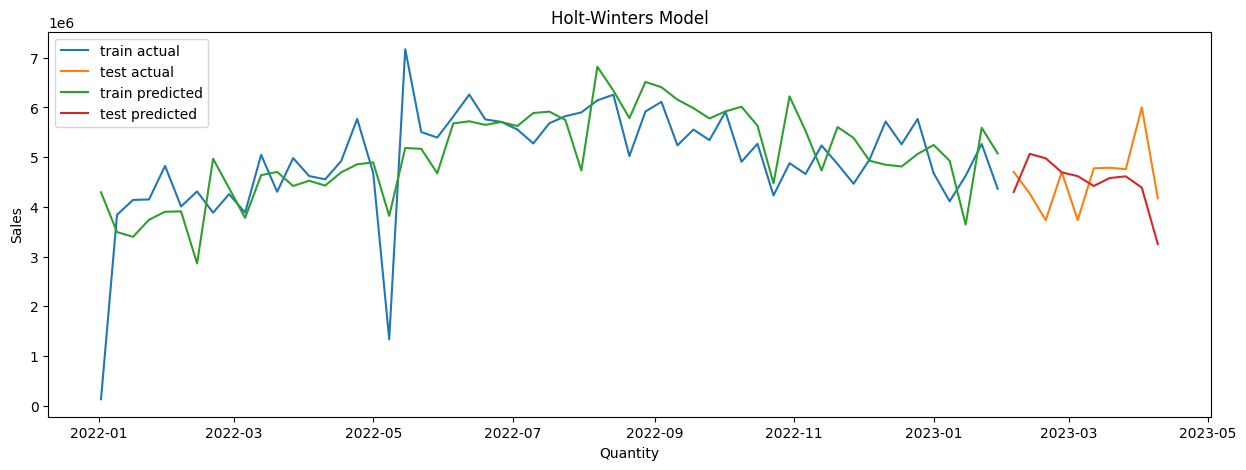

In [76]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.values, label='train actual')
plt.plot(test.index, test.values, label='test actual')
plt.plot(train_predictions.index, train_predictions.values, label='train predicted')
plt.plot(test_predictions.index, test_predictions.values, label='test predicted')
plt.title('Holt-Winters Model')
plt.xlabel('Quantity')
plt.ylabel('Sales')
plt.legend()
plt.show()

> Model Evaluation

In [77]:
print("MAE Train =", mean_absolute_error(train, train_predictions))
print("MAE test =", mean_absolute_error(test, test_predictions))

MAE Train = 642372.0313460799
MAE test = 658142.5878485787


* Model Holt-Winters berhasil memberikan hasil evaluasi yang baik dengan nilai MAE Train sebesar 642,372 dan MAE Test sebesar 658,143. MAE Test cukup stabil dan tidak terlalu jauh dari MAE Train, sehingga model ini dapat digunakan untuk memprediksi data di masa depan.

> Input hasil MAE ke dalam DataFrame

In [78]:
data_mae = {'Model': ['Model ARIMA', 'SARIMA (1)', 'SARIMA (2)', 'SARIMA (3)', 'SARIMA (4)', 'Holt Winters'], 
            'MAE Train': [792748.2395502614, 836297.5710424295, 823993.2215425053, 846958.6098581993, 1288661.0073951231, 642372.0313460799], 
            'MAE Test': [442610.30460846797, 836297.5710424295, 653516.9306824275, 729537.877542069, 910824.2692686388, 658142.5878485787]}
df_mae = pd.DataFrame(data_mae)
df_mae

,Model,MAE Train,MAE Test
0,Model ARIMA,7.927482e+05,442610.304608
1,SARIMA (1),8.362976e+05,836297.571042
2,SARIMA (2),8.239932e+05,653516.930682
3,SARIMA (3),8.469586e+05,729537.877542
4,SARIMA (4),1.288661e+06,910824.269269
5,Holt Winters,6.423720e+05,658142.587849


# Model Evaluation

Model	| MAE Train |	MAE Test
------ | ------ | -----
Model ARIMA |	792748.2395502614 | 442610.304608
SARIMA (1)	| 836297.5710424295	| 836297.571042
SARIMA (2)	| 823993.2215425053	| 653516.930682
SARIMA (3)	| 846958.6098581993	| 729537.877542
SARIMA (4)	| 1288661.0073951231 | 910824.2692686388
Holt Winters | 642372.0313460799	| 658142.587849

* Berdasarkan hasil evaluasi MAE Train dan MAE Test pada tabel di atas, dapat dilihat bahwa model terbaik adalah Holt Winters. Dengan nilai MAE Train yang lebih rendah dari model-model SARIMA dan MAE Test yang juga relatif rendah.


# Conclusion / Overall Analysis

> **Based on EDA**

* Terdapat 2309 unique value/product yang berbeda pada kolom "product_item" di dalam dataset dengan terdapat beberapa product item yang memiliki jumlah maksimum sebanyak 67 item dan beberapa product item yang memiliki jumlah paling sedikit sebanyak 1 item.
* Berdasarkan observasi awal, dapat diketahui bahwa proses yang diamati tidak stasioner dan sulit untuk menentukan adanya seasonality. Namun, setelah dilakukan decomposing, dapat dipastikan bahwa data yang kita temui merupakan data seasonality.

> **Based on Model Evaluation**

* Pada model Holt Winters menghasilkan MAE sebesar 642372.03134607994 pada data train dan 658142.587849 pada data test. Dengan nilai MAE Train yang lebih rendah dari model-model SARIMA dan MAE Test yang juga relatif rendah.

* Kelebihan dari model Holt Winters adalah mampu menangani data time series yang memiliki musimanitas dan tren secara bersamaan. Selain itu, model ini dapat menghasilkan hasil prediksi yang akurat dalam jangka waktu yang cukup lama.

* Namun, kelemahan dari model Holt Winters adalah model ini kurang fleksibel dalam menangani perubahan yang tiba-tiba pada data, seperti perubahan kebijakan atau situasi yang tidak terduga lainnya. Selain itu, model ini juga memerlukan banyak waktu dan komputasi yang tinggi untuk menghasilkan hasil prediksi pada jangka waktu yang panjang.

# Inferencing

In [79]:
# use the model to make a prediction
prediction = model_HW.predict(start='2023-04-16', end='2023-04-30')

# print the prediction values
print(prediction)

2023-04-16    5.007034e+06
2023-04-23    4.539480e+06
2023-04-30    3.891781e+06
Freq: W-SUN, dtype: float64


Didapatkan hasil jika menggunakan Holt Winters, pada periode berikutnya yaitu sekitar 3 minggu yang akan datang quantity product perusahaan akan mengalami penurunan yang signifikan

# Saving Model

In [80]:
# Save the Files

with open('model_forecasting.pkl', 'wb') as file_1:
  pickle.dump(model_HW, file_1)